In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from fsha import *
from datasets import image
from models import resnet
import pickle

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-03-02 16:35:07.379720: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-02 16:35:08.654567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17868 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:d8:00.0, compute capability: 7.5


In [3]:
target_ds, aux_ds = image.load_mnist()

In [4]:
batch_size = 64

hparams = {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001, # tuned
    'lr_tilde': 0.00001, # tuned
    'lr_D': 0.0001, # tuned
    'lr_g': 0.001 # given
}

iterations = 10000
log_frequency = 500

mnist_fsha = {}
log = {}

for split in [2,3,4]:
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    make_f, make_g, make_e, make_d, make_c = resnet.make_resnet_fsha(split=split, class_num=10)
    models = (make_f, make_g, make_e, make_d, make_c)

    # From "Unleashing the tiger: feature inference attacks in split learning"
    if split == 4:
        hparams['lr_D'] = 0.0005
        
    mnist_fsha["mnist-split="+str(split)] = FSHA(target_ds, aux_ds, models=models, batch_size=64, hparams=hparams)
    log["mnist-split="+str(split)] = mnist_fsha["mnist-split="+str(split)](iterations, verbose=True, progress_bar=False, log_frequency=log_frequency)

======Split level is 2======
RUNNING...
Use WGAN loss
Use GP
Use WGAN loss
Use GP


2022-03-02 16:35:20.409487: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-02 16:35:21.367424: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-02 16:35:21.368399: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-02 16:35:21.368420: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-02 16:35:21.369846: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-02 16:35:21.369917: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Iteration 0000000 train loss: 3.0619, validation: 0.9914
Iteration 0000500 train loss: 0.2986, validation: 0.4296
Iteration 0001000 train loss: 0.2114, validation: 0.0832
Iteration 0001500 train loss: 0.1916, validation: 0.0429
Iteration 0002000 train loss: 0.1768, validation: 0.0324
Iteration 0002500 train loss: 0.1719, validation: 0.0260
Iteration 0003000 train loss: 0.1720, validation: 0.0218
Iteration 0003500 train loss: 0.1616, validation: 0.0194
Iteration 0004000 train loss: 0.1487, validation: 0.0174
Iteration 0004500 train loss: 0.1537, validation: 0.0159
Iteration 0005000 train loss: 0.1435, validation: 0.0160
Iteration 0005500 train loss: 0.1391, validation: 0.0141
Iteration 0006000 train loss: 0.1218, validation: 0.0142
Iteration 0006500 train loss: 0.1374, validation: 0.0133
Iteration 0007000 train loss: 0.1108, validation: 0.0141
Iteration 0007500 train loss: 0.1201, validation: 0.0136
Iteration 0008000 train loss: 0.1020, validation: 0.0135
Iteration 0008500 train loss: 0

In [5]:
with open('log/mnist-fsha.pkl', 'wb') as f:
    pickle.dump(log, f)

tf.Tensor(0.01076522, shape=(), dtype=float32)
tf.Tensor(0.014501924, shape=(), dtype=float32)
tf.Tensor(0.014589225, shape=(), dtype=float32)


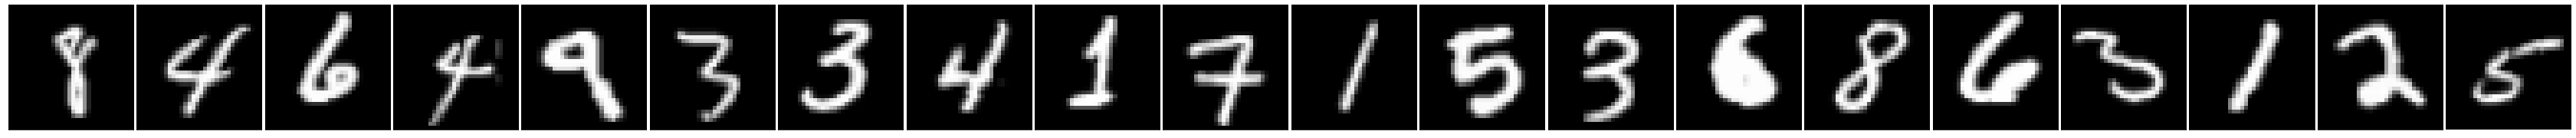

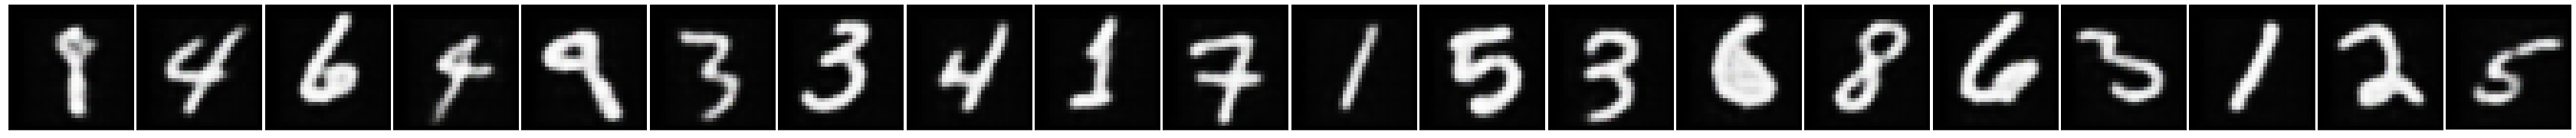

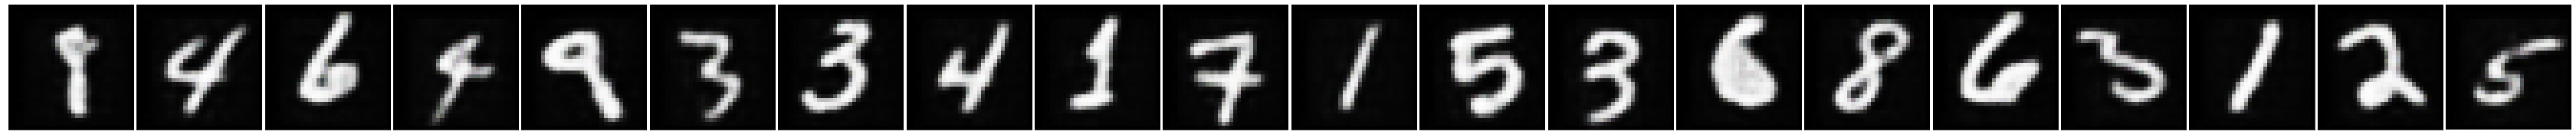

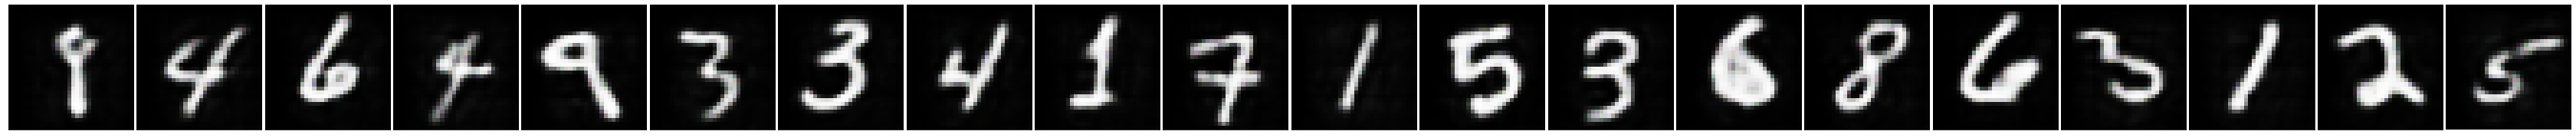

In [6]:
imgs = np.array([x[0].numpy() for x in target_ds.take(20)])

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno')
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
    return fig

fig = plot(imgs)

for split in [2,3,4]:
    rec_res, _ = mnist_fsha["mnist-split="+str(split)].attack(imgs)
    fig = plot(rec_res)
    print(tf.keras.losses.MeanSquaredError()(imgs, rec_res))

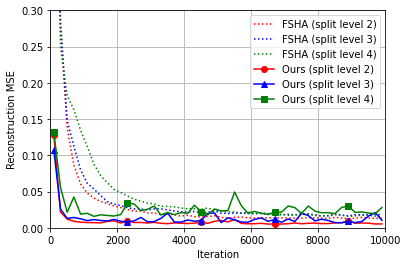

In [2]:
import pickle
import matplotlib.pyplot as plt

with open('log/mnist-fsha.pkl', 'rb') as f:
    log = pickle.load(f)

with open('log/mnist-all.pkl', 'rb') as f:
    log1 = pickle.load(f)

from matplotlib.pyplot import figure
# figure(figsize=(8,8))
log_freq = 200
# plt.yscale('logit')
plt.xlim([0,10000])
plt.ylim([0.00, 0.3])
plt.grid()
sampled_log_2 = [sum(log["mnist-split=2"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["mnist-split=2"][:,0])/log_freq))]
sampled_log_3 = [sum(log["mnist-split=3"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["mnist-split=3"][:,0])/log_freq))]
sampled_log_4 = [sum(log["mnist-split=4"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["mnist-split=4"][:,0])/log_freq))]
sampled_log1_2 = [sum(log1["mnist-split=2"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log1["mnist-split=2"][:,0])/log_freq))]
sampled_log1_3 = [sum(log1["mnist-split=3"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log1["mnist-split=3"][:,0])/log_freq))]
sampled_log1_4 = [sum(log1["mnist-split=4"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log1["mnist-split=4"][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(10000/log_freq))]
plt.plot(
    ran, sampled_log_2, 'r:',
    ran, sampled_log_3, 'b:',
    ran, sampled_log_4, 'g:',
    ran, sampled_log1_2, 'ro-',
    ran, sampled_log1_3, 'b^-',
    ran, sampled_log1_4, 'gs-',
    markevery=11)
plt.ylabel('Reconstruction MSE')
plt.xlabel('Iteration')
plt.legend(["FSHA (split level 2)", "FSHA (split level 3)", "FSHA (split level 4)", "Ours (split level 2)", "Ours (split level 3)", "Ours (split level 4)"])
plt.savefig("fig/mnist-fsha-dsa.pdf", bbox_inches='tight')